In [2]:
import pandas as pd
import datetime as dt
from pandas_profiling import ProfileReport
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
orderbook = pd.read_csv('df_order_book_20200817.csv')
(orderbook.isnull().sum()/len(orderbook)) * 100
orderbook.loc[:,'BidQuoteQty']= orderbook.loc[:,'bidPrice'] * orderbook.loc[:,'bidQty']
orderbook.loc[:,'AskQuoteQty'] = orderbook.loc[:,'askPrice'] * orderbook.loc[:,'askQty']
orderbook_100=orderbook.drop(orderbook[orderbook['depth']>99].index)
orderbook_100=orderbook_100.reset_index(drop=True)

In [4]:
# build corresbonding 

class Node:   
  def __init__(self): 
    # price, quantity and quoteQty
    self.bid = np.zeros((100, 3), dtype=float)
    self.ask = np.zeros((100, 3), dtype=float)
    self.spread=0
    

orderbook_list=[]
timestamps=set()
idx=0
while idx<len(orderbook_100):
  a=Node()
  for i in range(100):
    if idx>=len(orderbook_100):
      break
    
    a.bid[i][0]=orderbook_100['bidPrice'][idx]
    a.bid[i][1]=orderbook_100['bidQty'][idx]
    a.bid[i][2]=orderbook_100['BidQuoteQty'][idx]
    a.ask[i][0]=orderbook_100['askPrice'][idx]
    a.ask[i][1]=orderbook_100['askQty'][idx]
    a.ask[i][2]=orderbook_100['AskQuoteQty'][idx]
    idx=idx+1
  
  orderbook_list.append(a)

orderbook_list[0]
      

## pending order


## plot 

Text(0, 0.5, 'Quoto')

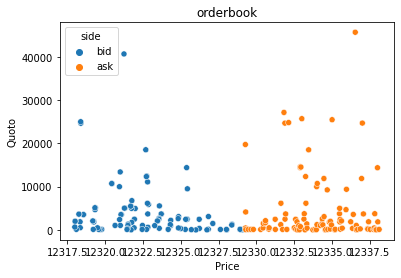

In [6]:
bid=pd.DataFrame(orderbook_list[0].bid, columns =['price', 'quantity', 'quote'], dtype = float) 
bid['side']='bid'
ask=pd.DataFrame(orderbook_list[0].ask, columns =['price', 'quantity', 'quote'], dtype = float) 
ask['side']='ask'
frames=[bid,ask]
result=pd.concat(frames)


fig, ax = plt.subplots()

ax.set_title(f"orderbook")

sns.scatterplot(x="price", y="quote", hue="side", data=result, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quoto")
